# Set Up

In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
import transformers
from datasets import load_dataset, concatenate_datasets, ClassLabel
import json
import pandas as pd
from openai import OpenAI
import ast
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, PeftModel
import matplotlib.pyplot as plt

/Users/squirrellover/Library/Python/3.10/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /Users/squirrellover/Library/Python/3.10/lib/python/site-packages/bitsandbytes/libbitsandbytes_cpu.so
'NoneType' object has no attribute 'cadam32bit_grad_fp32'
CUDA SETUP: Loading binary /Users/squirrellover/Library/Python/3.10/lib/python/site-packages/bitsandbytes/libbitsandbytes_cpu.so...
dlopen(/Users/squirrellover/Library/Python/3.10/lib/python/site-packages/bitsandbytes/libbitsandbytes_cpu.so, 0x0006): tried: '/Users/squirrellover/Library/Python/3.10/lib/python/site-packages/bitsandbytes/libbitsandbytes_cpu.so' (not a mach-o file), '/System/Volumes/Preboot/Cryptexes/OS/Users/squirrellover/Library/Python/3.10/lib/python/site-packages/bitsandbytes/libbitsandbytes_cpu.so' (no such file), '/Users/squirrellover/

/Users/squirrellover/Library/Python/3.10/lib/python/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [5]:
device = torch.device("mps")

In [ ]:
!huggingface-cli login --token nicetry


In [6]:
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    cache_dir="base_models_7b",
    device_map='auto',
    offload_folder="save_folder"
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:20<00:00, 10.23s/it]


In [7]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", cache_dir="base_models_7b", padding_side="left")

In [8]:
tokenizer.model_max_length = 1024
tokenizer.truncation = True 
tokenizer.padding = "max_length"

In [9]:
# https://github.com/TrelisResearch/llama-2-setup
# Check if the pad token is already in the tokenizer vocabulary
if '<pad>' not in tokenizer.get_vocab():
  # Add the pad token
  tokenizer.add_special_tokens({"pad_token":"<pad>"})

#Resize the embeddings
model.resize_token_embeddings(len(tokenizer))

#Configure the pad token in the model
model.config.pad_token_id = tokenizer.pad_token_id

# Check if they are equal
assert model.config.pad_token_id == tokenizer.pad_token_id, "The model's pad token ID does not match the tokenizer's pad token ID!"

# Print the pad token ids
print('Tokenizer pad token ID:', tokenizer.pad_token_id)
print('Model pad token ID:', model.config.pad_token_id)
print('Model config pad token ID:', model.config.pad_token_id)

Tokenizer pad token ID: 32000
Model pad token ID: 32000
Model config pad token ID: 32000


In [10]:
def get_response(prompt, max_new_tokens=2000):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, repetition_penalty = 1.18, temperature= 0.15)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Zero-Shot Inference

In [ ]:
rb_test = pd.read_csv('rarebench_data_test.csv')
correct = 0
zero_shot_predictions = []

for _, example in rb_test.iterrows():
    prompt = '''<s>[INST] <<SYS>>
            {{ You are a specialist in the field of rare diseases. You will be provided and
            asked about a complicated clinical case; read it carefully and then provide a diverse and
            comprehensive differential diagnosis. }}
            <</SYS>>

            {{ This rare disease patient suffers from symptoms: '''+ example["symptoms"] +'''. Enumerate the top 10 most likely diagnoses. Be precise,
            listing one diagnosis per line, and try to cover many unique possibilities (at least 10). The
            top 10 diagnoses are: }} [/INST]'''
    result = get_response(prompt)
    
    zero_shot_predictions.append({
        "symptoms": example["symptoms"],
        "diseases": example["diseases"],
        "predicted": result
    })    

    zero_shot_predictions = pd.DataFrame(zero_shot_predictions)

In [15]:
display(zero_shot_predictions)
zero_shot_predictions.to_csv("results/zero_shot_predictions.csv", index = False)

,0,1,2,4
0,"['Intellectual disability', 'Hypotonia', 'Glob...",['TBCK-related intellectual disability syndrom...,[INST] <<SYS>>\n {{ You are a speci...,False
1,"['Death in infancy', 'Aminoaciduria', 'Abnorma...",['3-Methylcrotonyl-CoA carboxylase 1 deficienc...,[INST] <<SYS>>\n {{ You are a speci...,False
2,"['Weight loss', 'Arthralgia', 'Elevated circul...","['Scleroderma, familial progressive', 'Systemi...",[INST] <<SYS>>\n {{ You are a speci...,False
3,"['Seizure', 'Spastic diplegia', 'Encephalopath...",['Glutaric acidemia type I; GA-I/Glutaryl-CoA ...,[INST] <<SYS>>\n {{ You are a speci...,True
4,"['Wide mouth', 'Epicanthus', 'Carious teeth', ...","['Hyperinsulinemic hypoglycemia, familial, 2',...",[INST] <<SYS>>\n {{ You are a speci...,False
...,...,...,...,...
415,"['Vesicoureteral reflux', 'Microretrognathia',...","['Mental retardation, autosomal dominant 42']",[INST] <<SYS>>\n {{ You are a speci...,False
416,"['Obesity', 'Death in infancy', 'Neutropenia',...",['Glycogen storage disease Ib/Glycogen storage...,[INST] <<SYS>>\n {{ You are a speci...,False
417,"['Eosinophilia', 'Lymphopenia', 'Increased cir...","['Candidiasis, familial chronic mucocutaneous,...",[INST] <<SYS>>\n {{ You are a speci...,False
418,"['Microcephaly', 'Ptosis', 'Myopia', 'Autism',...",['Intellectual developmental disorder with dys...,[INST] <<SYS>>\n {{ You are a speci...,False


# Fine-Tuning

In [10]:
dataset = load_dataset("csv", data_files="final_traindata/final_train_data.csv")

In [11]:
split = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_dataset = split["train"]
val_dataset = split["test"]

print(train_dataset)
print(val_dataset)

Dataset({
    features: ['text'],
    num_rows: 1854
})
Dataset({
    features: ['text'],
    num_rows: 207
})


In [12]:
train_dataset = train_dataset.map(lambda samples: tokenizer(samples["text"]), batched=True)
val_dataset = val_dataset.map(lambda samples: tokenizer(samples["text"]), batched=True)
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])
display(train_dataset)
display(val_dataset)

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1854
})

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 207
})

In [13]:
print(dataset["train"][0])

{'text': '[INST] <<SYS>> You are a specialist in the field of rare diseases. <</SYS>> Question: Rubella specific antibodies detected after vaccination/ natural infection: March 2013\nChoices:\nA. IgM\nB. IgG\nC. IgA\nD. IgE\nAnswer: [/INST] IgG </s>'}


In [16]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [17]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [18]:
config = LoraConfig(
    r=8, 
    lora_alpha=16, 
    target_modules=["q_proj", "v_proj"], 
    lora_dropout=0.2, 
    bias="none", 
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 4194304 || all params: 6742618112 || trainable%: 0.06220586618327525


In [20]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=transformers.TrainingArguments(
        remove_unused_columns=True,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=4,
        warmup_steps=50,
        num_train_epochs=3,
        learning_rate=5e-5,
        fp16= False,
        bf16 = True,
        logging_steps=20,
        output_dir="outputs",
        optim="paged_adamw_8bit",
        save_steps = 20, 
        logging_first_step=True,
        eval_strategy = "steps",  
        eval_steps = 20,  
        save_total_limit = 2,  
        load_best_model_at_end = True,  
        metric_for_best_model = "loss", 
        greater_is_better = False,
        weight_decay=0.01,
        lr_scheduler_type="cosine"            
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False, pad_to_multiple_of=8),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
20,2.503000,2.417950
40,2.221300,2.055367
60,1.852100,1.594290
80,1.454000,1.301015
100,1.221700,1.131562
120,1.099900,1.047253
140,1.040900,1.019945
160,1.024000,1.012615


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetunin

TrainOutput(global_step=174, training_loss=1.5093286434809368, metrics={'train_runtime': 1489.2722, 'train_samples_per_second': 3.735, 'train_steps_per_second': 0.117, 'total_flos': 1.4314887634354176e+17, 'train_loss': 1.5093286434809368, 'epoch': 3.0})

# Fine-Tuning Inference

In [ ]:
model = PeftModel.from_pretrained(model, "qlora_weights/finetune1_weights")
model = model.merge_and_unload()

In [ ]:
rb_test = pd.read_csv('rarebench_data_test.csv')
correct = 0
finetuned1_predictions = []
i = 0
for _, example in rb_test.iterrows():
    print(i)
    prompt = '''<s>[INST] <<SYS>>
            {{ You are a specialist in the field of rare diseases. You will be provided and
            asked about a complicated clinical case; read it carefully and then provide a diverse and
            comprehensive differential diagnosis. }}
            <</SYS>>

            {{ This rare disease patient suffers from symptoms: '''+ example["symptoms"] +'''. Enumerate the top 10 most likely diagnoses. Be precise,
            listing one diagnosis per line, and try to cover many unique possibilities (at least 10). The
            top 10 diagnoses are: }} [/INST]'''
    result = get_response(prompt)
    #print(result)
    #print("!"+example["diseases"])
    finetuned1_predictions.append({
        "symptoms": example["symptoms"],
        "diseases": example["diseases"],
        "predicted": result
    })  
    i += 1

finetuned1_predictions = pd.DataFrame(finetuned1_predictions)
finetuned1_predictions.to_csv("intermediate_data/finetuned1_predictions.csv", index = False)

# Graphs

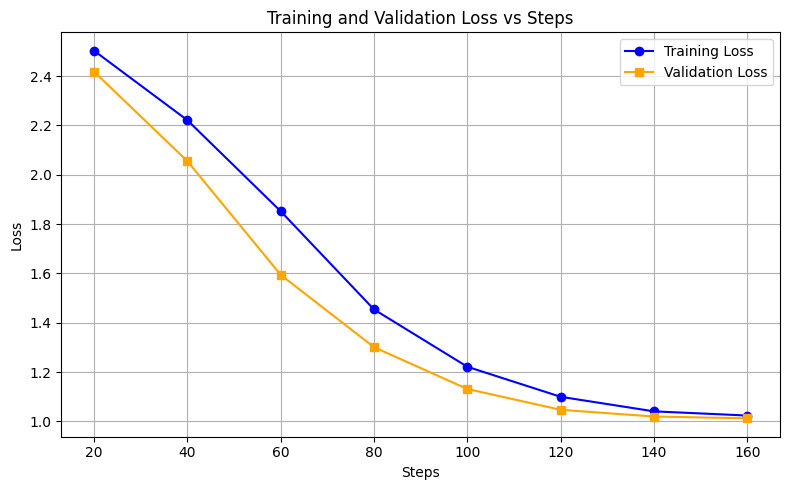

In [3]:
# Fine-tuning 1

steps = [20, 40, 60, 80, 100, 120, 140, 160]
training_loss = [2.503000, 2.221300, 1.852100, 1.454000, 1.221700, 1.099900, 1.040900, 1.024000]
validation_loss = [2.417950, 2.055367, 1.594290, 1.301015, 1.131562, 1.047253, 1.019945, 1.012615]

plt.figure(figsize=(8, 5))
plt.plot(steps, training_loss, label='Training Loss', marker='o', color='blue')
plt.plot(steps, validation_loss, label='Validation Loss', marker='s', color='orange')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


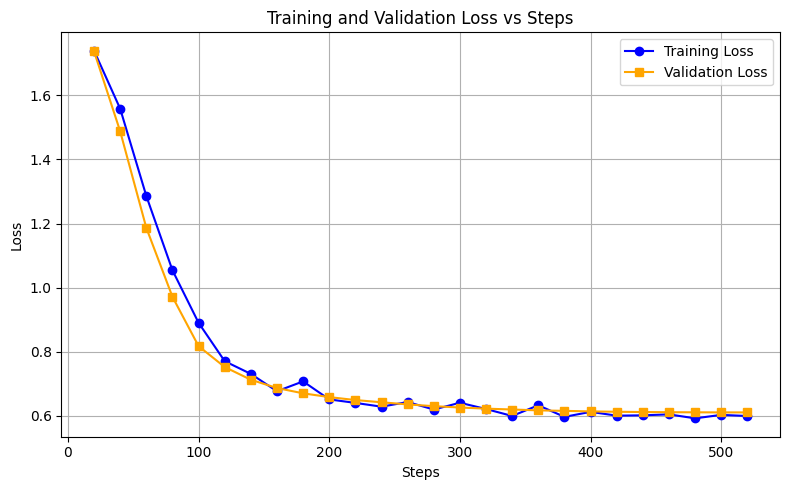

In [1]:
# Fine-tuning 2

steps = [
    20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 
    220, 240, 260, 280, 300, 320, 340, 360, 380, 400,
    420, 440, 460, 480, 500, 520
]
training_loss =    [1.7396, 1.5583, 1.286, 1.0541, 0.8901, 0.7703, 0.7306, 0.6765, 0.7073, 0.651,
    0.6401, 0.6283, 0.6428, 0.6194, 0.6406, 0.621, 0.5993, 0.6327, 0.5965, 0.6121,
    0.6003, 0.6013, 0.6043, 0.5919, 0.6027, 0.5992
]
validation_loss = [
    1.7374, 1.4877, 1.1865, 0.9713, 0.8172, 0.7521, 0.7124, 0.6865, 0.6700, 0.6582,
    0.6490, 0.6420, 0.6354, 0.6299, 0.6257, 0.6222, 0.6195, 0.6168, 0.6152, 0.6136,
    0.6124, 0.6116, 0.6111, 0.6107, 0.6105, 0.6104
]

plt.figure(figsize=(8, 5))
plt.plot(steps, training_loss, label='Training Loss', marker='o', color='blue')
plt.plot(steps, validation_loss, label='Validation Loss', marker='s', color='orange')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
